# Vehicle Detection and Tracking Project

- Perform HOG (Histogram of oriented Gradient) feature extraction on a labeled training set of images and train an SVM classifier
- Apply a color transform and append bnned color features to the HOG feature vector.
- Normalize features
- Train classifier on HOG and color features and combined
- Eventually use a Decision Tree for adding new features
- Implement sliding-window technique and use trained classifier to search for vehicles in the images
- Estimate a boudning box of vehicles detected
- Run your pipeline on a video stream and implement tracking to follow detected vehicles
- Estimate distance and trajectory of detected vehicles

## List of images to read in

number of Vehicle Images found:  8792
number of Vehicle Images found:  8968


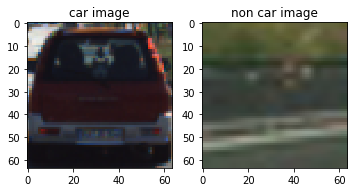

In [119]:
import os
import glob

# vehicle images
cars = []

base_dir = 'vehicles/'
image_types = os.listdir(base_dir)

for imtype in image_types:
    cars.extend(glob.glob(base_dir + imtype + '/*'))
    
print('number of Vehicle Images found: ', len(cars))
with open('cars.txt', 'w') as file:
    for file_name in cars:
        file.write(file_name + '\n')
        
# non vehicle images
non_cars = []

base_dir = 'non-vehicles/'
image_types = os.listdir(base_dir)

for imtype in image_types:
    non_cars.extend(glob.glob(base_dir + imtype + '/*'))
    
print('number of Vehicle Images found: ', len(non_cars))
with open('non_cars.txt', 'w') as file:
    for file_name in non_cars:
        file.write(file_name + '\n')
        
        
idx = np.random.randint(0, len(cars))
images = [mpimg.imread(cars[idx]), mpimg.imread(non_cars[idx])]
titles = ['car image', 'non car image']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)


## Imports

In [68]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import pickle
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Feature extraction functions

In [42]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    '''
    Function to return HOG features and visualization
    '''
    
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
    
def bin_spatial(img, size=(32, 32)):
    '''
    Function to perform spatial binning on the image.
    '''
    
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


def color_hist(img, nbins=32):
    '''
    Function to bin up each color channel to a histogram
    '''
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

## Helper functions

In [81]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    '''
    Function to extract features from a list of images
    '''
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    '''
    Function that takes an image, start and stop positions in both x and y, 
    window size (x and y dimensions),  and overlap fraction (for both x and y)
    '''
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    '''
    Function to draw bounding boxes
    '''
    
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):  
    '''
    Function to extract features from a single image window
    This function is very similar to extract_features()
    just for a single image rather than list of images
    '''
    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)


def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    '''
    Function you will pass an image 
    and the list of windows to be searched (output of slide_windows())
    '''
    
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


def convert_color(img, conv='RGB2YCrCb'):
    '''
    Function for converting in different color spaces
    '''
    
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


def visualize(fig, rows, cols, imgs, titles):
    '''
    Function for generating a fugure for multiple images
    '''
    
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
        else:
            plt.imshow(img)
            
        plt.title(titles[i])

## Extraction

In [52]:
%matplotlib inline

/Users/mathiasvonkaiz/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


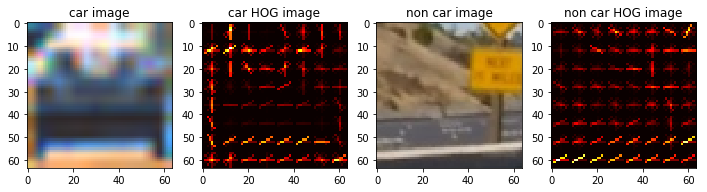

In [60]:
# Choose random car / non car
car_ind = np.random.randint(0, len(cars))
non_car_ind = np.random.randint(0, len(non_cars))

# read in car / non car images
car_image = mpimg.imread(cars[car_ind])
non_car_image = mpimg.imread(non_cars[non_car_ind])

# Defin feature parameters
color_space = 'RGB' # RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # 0, 1, 2 or 'ALL'
spatial_size = (16, 16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

non_car_features, non_car_hog_image = single_img_features(non_car_image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

images = [car_image, car_hog_image, non_car_image, non_car_hog_image]
titles = ['car image', 'car HOG image', 'non car image', 'non car HOG image']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)

## Training a Classifier

In [66]:
# Defin feature parameters
color_space = 'YCrCb' # RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # 0, 1, 2 or 'ALL'
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

t = time.time()
n_samples = 1000
random_idxs = np.random.randint(0, len(cars), n_samples)
test_cars = cars # np.array(cars)[random_idxs] # cars 
test_non_cars = non_cars # np.array(non_cars)[random_idxs] # non_cars

car_features = extract_features(test_cars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

non_car_features = extract_features(test_non_cars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time()-t, 'Seconds to compute features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, non_car_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block',
     hist_bins, 'histogram bins, and', spatial_size,'spatial sampling')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
# t=time.time()
# n_predict = 10
# print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
# print('For these',n_predict, 'labels: ', y_test[0:n_predict])
# t2 = time.time()
# print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

/Users/mathiasvonkaiz/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


204.440927028656 Seconds to compute features...
Using: 9 orientations 8 pixels per cell and 2 cells per block 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460
22.88 Seconds to train SVC...
Test Accuracy of SVC =  0.9901


## Save classifier to disk

In [69]:
with open('svc_classifier.pkl', 'wb') as f:
    pickle.dump(svc, f)

## Windowing

/Users/mathiasvonkaiz/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.49786901473999023 seconds to process one image searching 100 windows
0.5110921859741211 seconds to process one image searching 100 windows
0.5089988708496094 seconds to process one image searching 100 windows
0.493084192276001 seconds to process one image searching 100 windows
0.48114585876464844 seconds to process one image searching 100 windows
0.476470947265625 seconds to process one image searching 100 windows


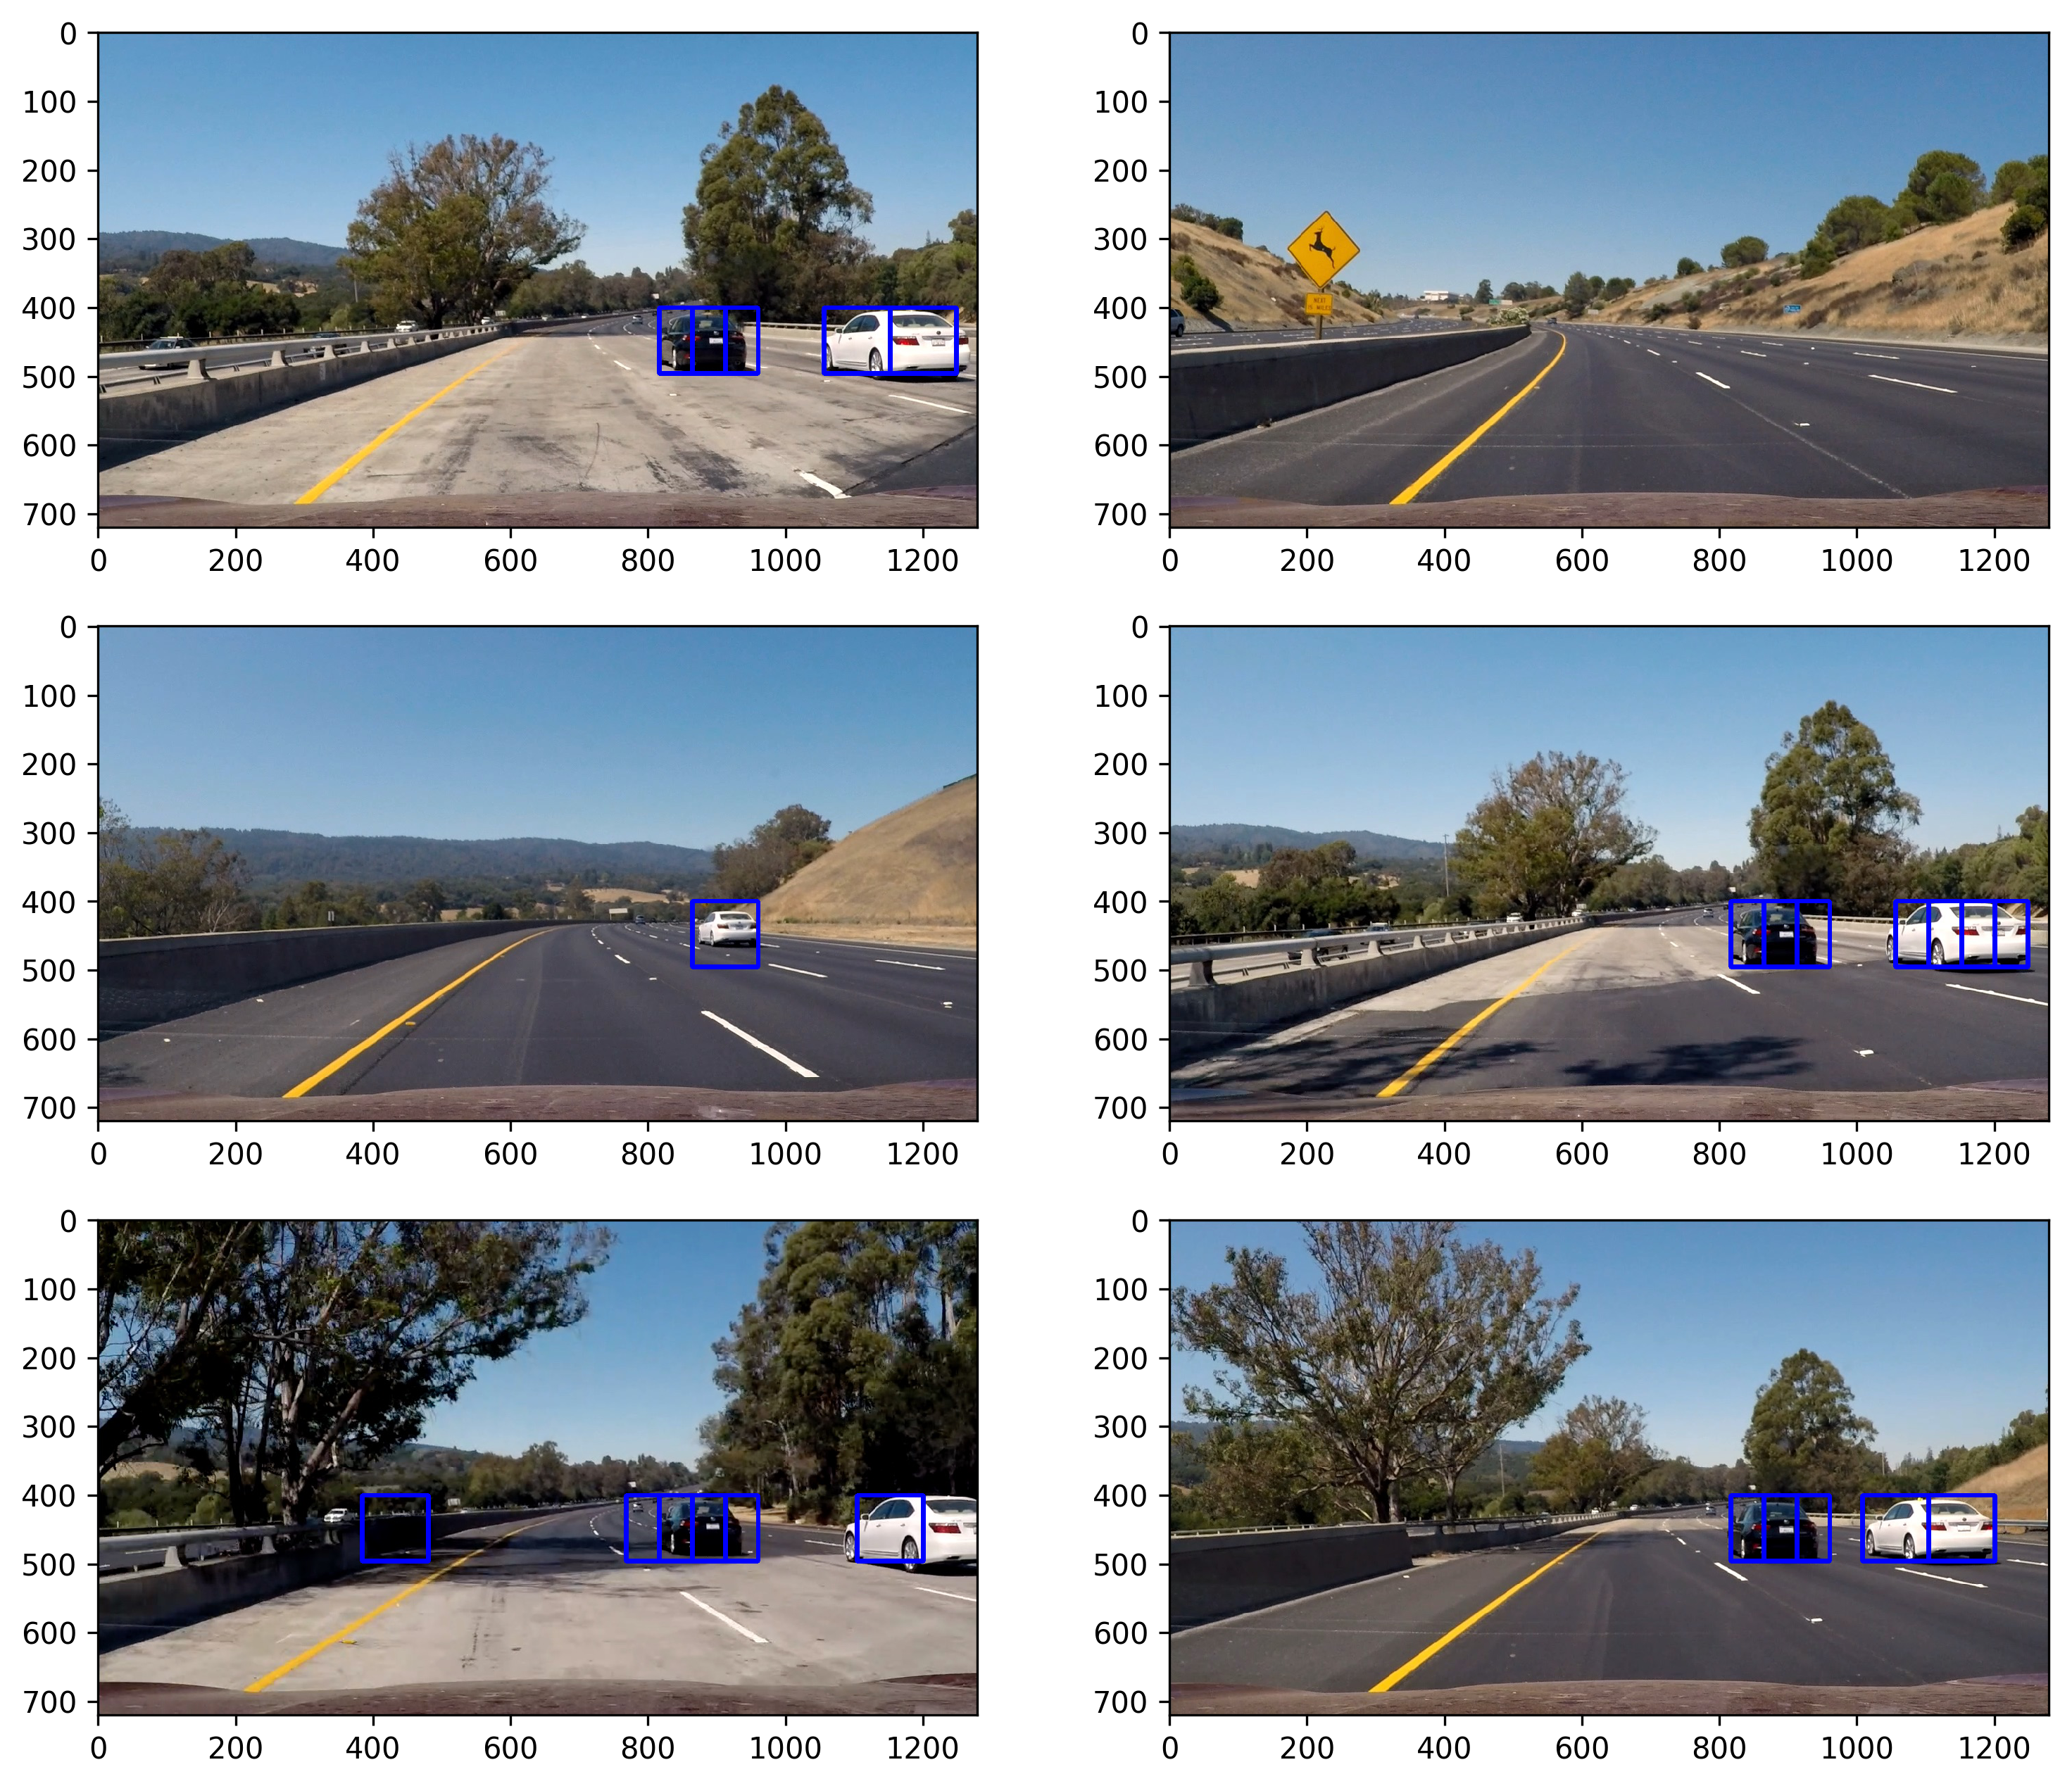

In [84]:
search_path = 'test_images/*'
example_images = glob.glob(search_path)
images = []
titles = []
y_start_stop = [400, 655] # min and max in y to search in slide_window()
overlap = 0.5
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img= img.astype(np.float32) / 255 # important as we now reading in jpgs and train on pngs
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(overlap, overlap))
    
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)     
    
    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'seconds to process one image searching', len(windows), 'windows')
    
fig = plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 5, 2, images, titles)

## Alternative approach:
## First calculate HOG and then subsample windows to gain performance

/Users/mathiasvonkaiz/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.37442588806152344 seconds to run, total windows =  294
0.36014795303344727 seconds to run, total windows =  294
0.3615260124206543 seconds to run, total windows =  294
0.37590503692626953 seconds to run, total windows =  294
0.3637540340423584 seconds to run, total windows =  294
0.35863804817199707 seconds to run, total windows =  294


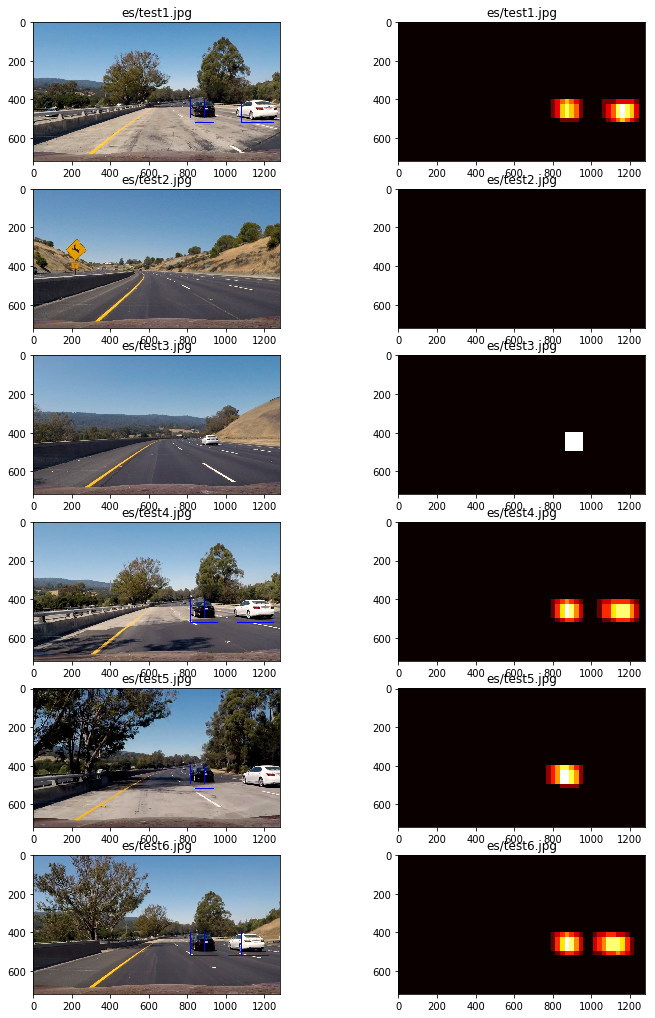

In [97]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []

y_start = 400
y_stop = 655
scale = 1.5 # trick searching different window sizes

# Iterate over images
for img_src in example_images:
    img_boxes = []
    t = time.time()
    count = 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    
    # Make heatmap of zeros
    heat_map = np.zeros_like(img[:, :, 0])
    img = img.astype(np.float32) / 255
    
    img_to_search = img[y_start:y_stop,:,:]
    c_trans_to_search = convert_color(img_to_search, conv='RGB2YCrCb')
    if scale != 1:
        img_shape = c_trans_to_search.shape
        c_trans_to_search = cv2.resize(c_trans_to_search, (np.int(img_shape[1] / scale), np.int(img_shape[0] / scale)))
        
    ch_1 = c_trans_to_search[:, :, 0]
    ch_2 = c_trans_to_search[:, :, 1]
    ch_3 = c_trans_to_search[:, :, 2]
    
    # Define steps and blocks
    n_x_blocks = (ch_1.shape[1] // pix_per_cell) - 1
    n_y_blocks = (ch_1.shape[0] // pix_per_cell) - 1
    n_feat_per_block = orient * cell_per_block**2
    window = 64
    n_blocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 # Instead of overlap, define how many cells to step
    n_x_steps = (n_x_blocks - n_blocks_per_window) // cells_per_step
    n_y_steps = (n_y_blocks - n_blocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog_1 = get_hog_features(ch_1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog_2 = get_hog_features(ch_2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog_3 = get_hog_features(ch_3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for x_b in range(n_x_steps):
        for y_b in range(n_y_steps):
            count += 1
            y_pos = y_b * cells_per_step
            x_pos = x_b * cells_per_step
            
            # Extract HOG for this patch
            hog_feat_1 = hog_1[y_pos:y_pos+n_blocks_per_window, x_pos:x_pos+n_blocks_per_window].ravel()
            hog_feat_2 = hog_2[y_pos:y_pos+n_blocks_per_window, x_pos:x_pos+n_blocks_per_window].ravel()
            hog_feat_3 = hog_3[y_pos:y_pos+n_blocks_per_window, x_pos:x_pos+n_blocks_per_window].ravel()
            hog_features = np.hstack((hog_feat_1, hog_feat_2, hog_feat_3))
            
            x_left = x_pos * pix_per_cell
            y_top = y_pos * pix_per_cell
            
            # Extract the image patch
            sub_img = cv2.resize(c_trans_to_search[y_top:y_top+window, x_left:x_left+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(sub_img, size=spatial_size)
            hist_features = color_hist(sub_img, nbins=hist_bins)
            
            # Scale features and make prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                x_box_left = np.int(x_left * scale)
                y_top_draw = np.int(y_top * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img, (x_box_left, y_top_draw+y_start), (x_box_left+win_draw, y_top_draw+win_draw+y_start), (0,0,255))
                img_boxes.append(((x_box_left, y_top_draw+y_start), (x_box_left+win_draw, y_top_draw+win_draw+y_start)))
                heat_map[y_top_draw+y_start:y_top_draw+win_draw+y_start, x_box_left:x_box_left+win_draw] += 1
                
    print (time.time()-t, 'seconds to run, total windows = ', count)
    
    out_images.append(draw_img)
    
    out_titles.append(img_src[-12:])
    out_titles.append(img_src[-12:])
    out_images.append(heat_map)
    out_maps.append(heat_map)
    out_boxes.append(img_boxes)
    
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

## Find cars

In [103]:
def find_cars(img, scale):
    '''
    Function for finding cars and drawing rectangles on them
    '''
    
    draw_img = np.copy(img)
    count = 0
    
    # Make heatmap of zeros
    heat_map = np.zeros_like(img[:, :, 0])
    img = img.astype(np.float32) / 255
    
    img_to_search = img[y_start:y_stop,:,:]
    c_trans_to_search = convert_color(img_to_search, conv='RGB2YCrCb')
    if scale != 1:
        img_shape = c_trans_to_search.shape
        c_trans_to_search = cv2.resize(c_trans_to_search, (np.int(img_shape[1] / scale), np.int(img_shape[0] / scale)))
        
    ch_1 = c_trans_to_search[:, :, 0]
    ch_2 = c_trans_to_search[:, :, 1]
    ch_3 = c_trans_to_search[:, :, 2]
    
    # Define steps and blocks
    n_x_blocks = (ch_1.shape[1] // pix_per_cell) - 1
    n_y_blocks = (ch_1.shape[0] // pix_per_cell) - 1
    n_feat_per_block = orient * cell_per_block**2
    window = 64
    n_blocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 # Instead of overlap, define how many cells to step
    n_x_steps = (n_x_blocks - n_blocks_per_window) // cells_per_step
    n_y_steps = (n_y_blocks - n_blocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog_1 = get_hog_features(ch_1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog_2 = get_hog_features(ch_2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog_3 = get_hog_features(ch_3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for x_b in range(n_x_steps):
        for y_b in range(n_y_steps):
            count += 1
            y_pos = y_b * cells_per_step
            x_pos = x_b * cells_per_step
            
            # Extract HOG for this patch
            hog_feat_1 = hog_1[y_pos:y_pos+n_blocks_per_window, x_pos:x_pos+n_blocks_per_window].ravel()
            hog_feat_2 = hog_2[y_pos:y_pos+n_blocks_per_window, x_pos:x_pos+n_blocks_per_window].ravel()
            hog_feat_3 = hog_3[y_pos:y_pos+n_blocks_per_window, x_pos:x_pos+n_blocks_per_window].ravel()
            hog_features = np.hstack((hog_feat_1, hog_feat_2, hog_feat_3))
            
            x_left = x_pos * pix_per_cell
            y_top = y_pos * pix_per_cell
            
            # Extract the image patch
            sub_img = cv2.resize(c_trans_to_search[y_top:y_top+window, x_left:x_left+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(sub_img, size=spatial_size)
            hist_features = color_hist(sub_img, nbins=hist_bins)
            
            # Scale features and make prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                x_box_left = np.int(x_left * scale)
                y_top_draw = np.int(y_top * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img, (x_box_left, y_top_draw+y_start), (x_box_left+win_draw, y_top_draw+win_draw+y_start), (0,0,255))
                img_boxes.append(((x_box_left, y_top_draw+y_start), (x_box_left+win_draw, y_top_draw+win_draw+y_start)))
                heat_map[y_top_draw+y_start:y_top_draw+win_draw+y_start, x_box_left:x_box_left+win_draw] += 1
                
    return draw_img, heat_map

In [104]:
from scipy.ndimage.measurements import label

def apply_threshold(heat_map, threshold):
    '''
    Function for applying a threshold on the heat map
    '''
    
    # zero out pixels below threshold
    heat_map[heat_map <= threshold] = 0
    
    # return thresholded map
    return heat_map

def draw_labeled_bboxes(img, labels):
    '''
    Function for drawing rectangles on each found car
    '''
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzero_y = np.array(nonzero[0])
        nonzero_x = np.array(nonzero[1])
        
        # Define a boudning box based on min/max x and y
        bbox = ((np.min(nonzero_x), np.min(nonzero_y)), (np.max(nonzero_x), np.max(nonzero_y)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
    return img

/Users/mathiasvonkaiz/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


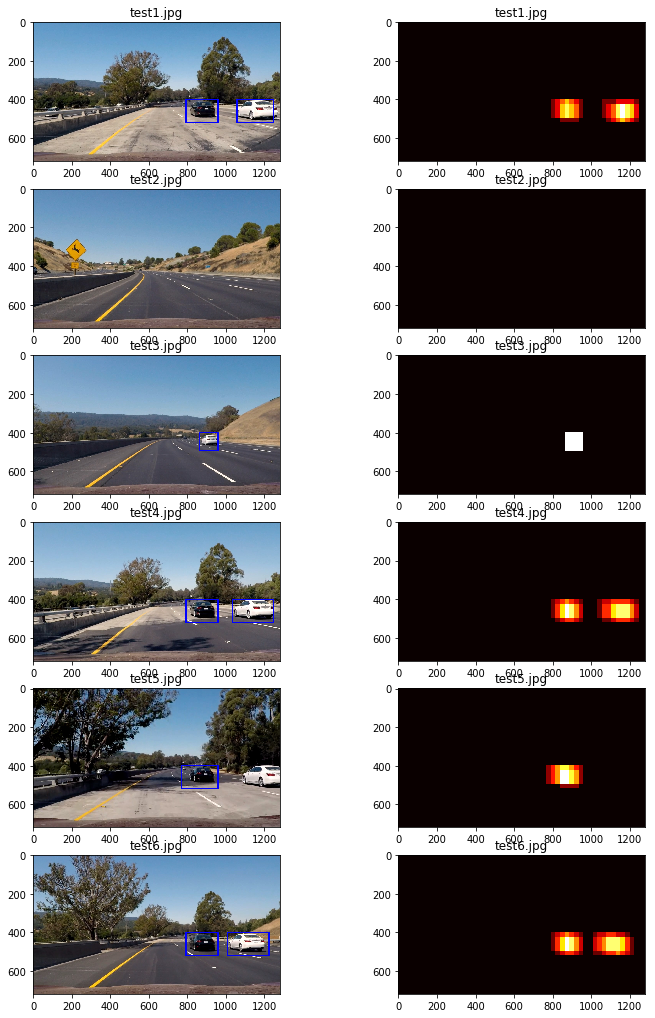

In [110]:
out_images = []
out_maps = []
out_boxes = []
out_titles = []

y_start = 400
y_stop = 655
scale = 1.5 # trick searching different window sizes

# Iterate over images
for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img, heat_map = find_cars(img, scale)
    labels = label(heat_map)
    
    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)
    out_titles.append(img_src[-9:])
    out_titles.append(img_src[-9:])
    
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)


## Apply on video

In [112]:
def process_image(img):
    out_ig, heat_map = find_cars(img, scale)
    labels = label(heat_map)
    
    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

In [116]:
# Import video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'test.mp4'

clip = VideoFileClip('project_video.mp4')
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)

  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


100%|█████████▉| 1260/1261 [07:05<00:00,  2.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

